## 数据读取函数

In [7]:
import pandas as pd
import numpy as np
import time,datetime
import matplotlib.pyplot as plt
import pywt
#读取相应txt文件
def read_txt(data):
    df=pd.read_json(data,encoding='UTF-8')
    columns=['busSpeed','gatherTime','sationUuid','sationName']
    df=df[columns]
    df.dropna()
    time1=list()
    for i in range(len(df.gatherTime)):
        time1.append(timestamp_to_date(timestamp_to_timestamp10(df.gatherTime[i])))
    df['Time']=time1
    df.set_index('Time',inplace=True)
    return df
#   df.to_excel('d:/gps/data.xlsx')
#将13位时间戳转换为10位时间戳
def timestamp_to_timestamp10(time_stamp):
    time_stamp = int (time_stamp* (10 ** (10-len(str(time_stamp)))))
    return time_stamp
#时间格式的转换
def timestamp_to_date(time_stamp, format_string="%Y-%m-%d %H:%M:%S"):
    time_array = time.localtime(time_stamp)
    str_date = time.strftime(format_string, time_array)
    return str_date

In [23]:
df=read_txt('d:gps/gps/2017-09-23/32/70205.txt')
df.to_excel('d:70325.xlsx')

## 数据平滑及数据去噪函数

In [14]:
def wt(index_list,data,wavefunc,lv,m,n,N):   # 打包为函数，方便调节参数。  lv为分解层数；data为最后保存的dataframe便于作图；index_list为待处理序列；wavefunc为选取的小波函数；m,n则选择了进行阈值处理的小波系数层数
   
    # 分解
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   # 按 level 层分解，使用pywt包进行计算， cAn是尺度系数 cDn为小波系数

    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn函数

    # 去噪过程
    for i in range(m,n+1):   # 选取小波系数层数为 m~n层，尺度系数不需要处理
        cD = coeff[i]
        for j in range(len(cD)):
            Tr = np.sqrt(2*np.log(len(cD)))  # 计算阈值
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) - Tr  # 向零收缩
            else:
                coeff[i][j] = 0   # 低于阈值置零

    # 重构
    denoised_index = pywt.waverec(coeff,wavefunc)
    
    # 在原dataframe中添加处理后的列便于画图
   # data['denoised_index']=pd.Series('x',index=data.index)
    weight=np.hanning(N)
    sam=np.convolve(weight/weight.sum(),denoised_index)[N:]
    #data['denoised_index']=pd.Series(np.array(sam),index=data.index)
   # for i in range(len(data)):
       # data['denoised_index'][i] =float(sam[i])
#    data.plot(figsize=(20,20),subplots=(2,1))

    # 画图
#    data.plot(figsize=(20,10))
    return sam

### 实例一：选取数据框制定行去噪

In [15]:
import numpy as np
import pandas as pd

In [16]:
df=pd.read_excel('d:07-09.xlsx')
columns=['32_0','32_1','32_2','32_3']
df.columns=columns
df.describe()

,32_0,32_1,32_2,32_3
count,293.000000,280.000000,276.000000,327.000000
mean,13.610922,13.560714,14.467391,11.987768
std,12.860107,11.624496,13.463851,12.273463
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,12.000000,14.000000,14.000000,9.000000
75%,24.000000,24.000000,25.000000,25.000000
max,40.000000,37.000000,44.000000,37.000000


In [5]:
df.fillna(-9999,inplace=True)
df.describe()

,20,9,11,14
count,327.000000,327.000000,327.000000,327.000000
mean,-1027.455657,-1425.553517,-1547.266055,11.987768
std,3060.845200,3517.972660,3638.680711,12.273463
min,-9999.000000,-9999.000000,-9999.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,9.000000,9.000000,7.000000,9.000000
75%,24.000000,24.000000,24.000000,25.000000
max,40.000000,37.000000,44.000000,37.000000


In [17]:
#df=pd.read_excel('d:data/12.xlsx')
#df.dropna(inplace=True)
#df[(np.abs(df)>=33)]=np.sign(df)*3
for i in range(0,len(df.columns)):
    index_list=np.array(df[df.columns[i]])
    sam=wt(index_list,df[df.columns[i]],'db4',4,1,2,10)
    df['denoised_index'+df.columns[i]]=np.array(sam)

In [18]:
df.to_excel('d:07-09_de.xlsx')

In [19]:
df.describe()

,32_0,32_1,32_2,32_3,denoised_index32_0,denoised_index32_1,denoised_index32_2,denoised_index32_3
count,293.000000,280.000000,276.000000,327.000000,188.000000,172.000000,172.000000,327.000000
mean,13.610922,13.560714,14.467391,11.987768,13.949876,14.381172,16.499988,11.686137
std,12.860107,11.624496,13.463851,12.273463,6.215152,5.301280,7.086977,8.084980
min,0.000000,0.000000,0.000000,0.000000,2.151400,2.188229,-0.915086,-1.819330
25%,0.000000,0.000000,0.000000,0.000000,8.435702,10.536953,11.571412,3.278923
50%,12.000000,14.000000,14.000000,9.000000,14.191668,15.478570,18.521619,12.845926
75%,24.000000,24.000000,25.000000,25.000000,18.120206,18.768634,21.932017,18.162841
max,40.000000,37.000000,44.000000,37.000000,29.090054,24.345082,27.194829,27.311210


In [32]:
df=pd.read_excel('d:data/12.xlsx')
df1=pd.read_excel('d:data/12.denoised.xlsx')

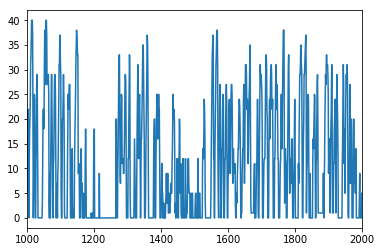

In [29]:
df.busspeed[1000:2000].plot()
plt.show()

In [24]:
df.to_excel('d:/data/12.denoised.xlsx')

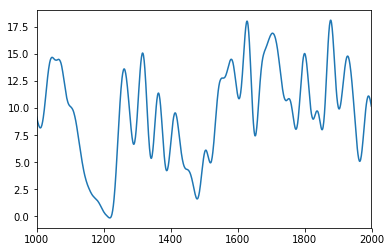

In [33]:
df1.denoised_indexbusspeed[1000:2000].plot()
plt.show()

In [11]:
index_list=np.array(df[df.columns[1]])
sam=wt(index_list,df[df.columns[i]],'db4',4,1,2,50)
len(df)

4304

In [110]:

df[(np.abs(df)>=35)]=np.sign(df)*3

In [111]:
df.describe()

,32_1,32_2,32_3,32_4,73_1,73_2,73_3,73_4
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,12.348061,11.441819,11.802980,10.943231,9.752633,9.416132,9.245826,9.956589
std,11.396495,10.840809,10.893154,10.992832,10.429876,10.441043,10.520007,10.601025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,11.000000,11.000000,9.000000,5.000000,5.000000,3.000000,5.000000
75%,24.000000,22.000000,22.000000,22.000000,18.000000,18.000000,18.000000,20.000000
max,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000


In [112]:
df.dropna(inplace=True)
for i in range(0,len(df.columns)):
    index_list=np.array(df[df.columns[i]])
    sam=wt(index_list,df[df.columns[i]],'db4',4,1,2,50)
    df['denoised_index'+df.columns[i]]=np.array(sam)

In [130]:
df=pd.read_excel('d:data/9_20_fill_labels.xlsx',index_col=1)
df.index=pd.to_datetime(df.index)
df['hour']=df.index.hour
df['min']=df.index.minute

,Time,busSpeed,denoised_index,labels,hour,min
2017-09-20 06:45:27,0,27,0.000000,1,6,45
2017-09-20 06:45:33,1,33,0.018933,1,6,45
2017-09-20 06:45:39,2,37,0.096211,1,6,45
2017-09-20 06:45:40,3,37,0.270538,1,6,45
2017-09-20 06:45:46,4,31,0.574602,1,6,45
2017-09-20 06:45:49,5,31,1.030314,1,6,45
2017-09-20 06:45:52,6,27,1.652561,1,6,45
2017-09-20 06:56:10,7,11,2.454320,1,6,56
2017-09-20 06:56:16,8,18,3.433418,1,6,56
2017-09-20 06:56:22,9,16,4.578691,1,6,56


#### 保存数据

In [15]:
df1_.to_excel('d:data/9-20-32-36574_4_nosam.xlsx')

### 选取制定条件所在列数据为NAN，进行去噪的函数

In [126]:
import pandas as pd
import numpy as np
df=read_txt('d:/gps/2017-09-20/32/36574.txt')
#df.index=pd.to_datetime(df.index)
#df.sationUuid.interpolate(method='bfill',inplace=True)
#df.dropna(subset=['sationUuid','busSpeed'],inplace=True)
mask=((((df.sationUuid=='1')|(df.sationUuid=='27')))&(df.busSpeed<10))
df.loc[mask,'busSpeed']=np.nan
#df.busSpeed.dropna(inplace=True)
df.to_excel('e:/filldata/9_20_32.xlsx')

In [128]:
import pandas as pd
import numpy as np
df=read_txt('d:/gps/2017-09-20/32/钂橝70286.txt')
df.to_excel('d:data/9-20/70286.xlsx')

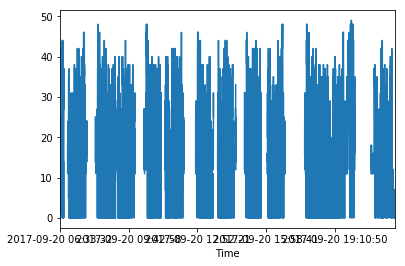

<Figure size 1800x1800 with 0 Axes>

In [11]:
%matplotlib inline
df.busSpeed.plot()
plt.figure(figsize=(25,25))
plt.show()

###  loc函数主要用于选取函数中的特定项，可用函数选取，选取符合条件的值进行处理

In [8]:
df=read_txt('d:/gps/2017-09-24/32/36574.txt')
#df1=df.loc[df['sationName']=='土默特中学']
index_list=np.array(df.busSpeed)
df2=wt(index_list,df,'db4',4,1,4,6)
df2.to_excel('e:tmtzx/9_24_32.xlsx')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### 函数可以做预测进行填充再去噪。

### 判断语句结束后得到的是一种布尔型的量，如果想要运用，还需要对其进行转换，如不，会产生以下错误（30）：
The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [34]:
final_list=[x for x in df.busSpeed if(np.float(x>df_mean-2*df_std))]
final_list=[x for x in final_list if(np.float(x<df_mean+2*df_std))]